# Intro

This notebook should be providing a brief overview of the optimization algorithm used to determine the clearing price as well as the reasoning behind the design choices involved. 

Let's first start out by briefly summarizing the auction characteristics as well as the requirements towards the optimization algorithm. 

## Auction

* A fixed number of tokens will be offered for sale in an auction
* over a limited period of time bids will be accepted
* each bid consists of an address and the bidding amount (some float value of ETH)
* after the time period is over this data is "handed over to" (consumed by) an optimisation engine to determine the distribution of tokens (and the resulting price per token. 
   * Sidenote: in reality the algorithm will also be used for intermediate calculations for current clearing price while the auction is still running. However this happens in scheduled refreshes and results are cached. Therefore the runtim of the algorithm is not a critical factor for frontend performance.


## Optimisation Goals
* maximize total revenue generated with auction

## Optimisation Constraints / Distribution Logic

* distribute all tokens
* users can only get full tokens 
    * remaining bids have to be reimbursed: total_bid - (price * tokens_assigned)
* addresses which do not get any token get their full bid reimbursed

**Note: not all of the above mechanism parts are part of the core optimization algorithm presented here.**

# Algorithm Choice

Of course there are a variety of choices available in such a scenario and this notebook cannot be expected to give an overview of all options.

## Other Alternative
Initially we considered going with a binary search tree algorithm. This showed very promising results and extremely fast runtimes. However upon closer examination we discovered irregularities in the relationship between potential clearing price and total revenue. So there were realistic scenarios where such an algorithm would not have delivered optimal results.

## Full Search
Given no strict requirements on runtime and the low number of tokens to be sold we decided to go with a full search over solution space. It roughly works like this:

1. Given a certain granularity, split the 1-D space of potential prices into n potential candidate prices
2. For all potential candidates determine the resulting volume of tokens distributed
3. For all candidate prices which result in exactly n tokens distributed return the clearing price which gives the highest overall revenue.

In [2]:
import numpy as np
import pandas as pd

class Optimizer():
    def __init__(self, total_tokens, bids=None):
        if bids is None:
            bids = self.obtain_bids()
        
        # some reformatting as we only needs bidder:bid format
        bids_reformatted = {bid:values["contribution_in_wei"] for bid, values in bids.items()}
        self.bids = bids_reformatted
        
        self.total_tokens = total_tokens
    
    def determine_volume(self, price):
        #token_distribution = {}
        bid_prices = [_ for _ in self.bids.values()]
        # order bids by price (caution: happens in place with lists)
        bid_prices.sort(reverse=True)
        # assign full tokens until all bids covered or bid < price:
        sold_tokens = 0
        for bid in bid_prices:
            assigned_tokens = bid // price
            sold_tokens += assigned_tokens
            
            if price > bid:
                #token_distribution[price] = 
                break
        return sold_tokens
    
    def calculate_full_range(self, minimum_price, granularity):
        
        prices = [price for price in self.bids.values()]
        
        candidate_prices = {_: {"volume": 0, "total_revenue":0} for _ in np.linspace(minimum_price, max(prices), granularity)}
        
        for candidate_price in candidate_prices.keys():
            volume = self.determine_volume(candidate_price)
            candidate_prices[candidate_price]["volume"] = volume
            candidate_prices[candidate_price]["total_revenue"] = volume * candidate_price
        
        return candidate_prices
    
    def calculate_clearing_price(self, minimum_price=0.00001, granularity=10000):
        result_range = self.calculate_full_range(minimum_price, granularity)
        df = pd.DataFrame(result_range).T
        self.df = df
        clearing_price = (
            df
            .query("volume <= @self.total_tokens")
            .reset_index()
            .sort_values(["index", "total_revenue"])
            .iloc[0,:]
            ['index']
        )
        return clearing_price

## Generating sample data

In case we want to test with artifical data:

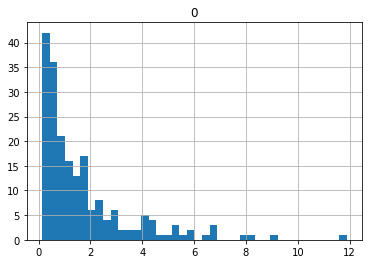

In [5]:
# setting input parameters
n_bidders = 200
log_normal_mu = 0
log_normal_sd = 1

bids = np.random.lognormal(log_normal_mu, log_normal_sd, size=n_bidders)

_ = pd.DataFrame(bids).hist(bins=40)

Reformat to match the input format expected for the algorithm.

In [6]:
#Packing into a dictionary
addresses = [f'address_{_}' for _ in np.arange(n_bidders)]

b_a = {addr:{"contribution_in_wei": bid} for addr,bid in zip(addresses, bids)}

## Running Optimizer

In [7]:
n_tokens = 150
opt = Optimizer(n_tokens, b_a)

In [9]:
%%time
clearing_price = opt.calculate_clearing_price(granularity=100000)

CPU times: user 5.28 s, sys: 30.1 ms, total: 5.31 s
Wall time: 5.31 s


As mentioned we have a runtim that is way too high for any live usage but given our setup is perfectly feasible. 

In [65]:
clearing_price

0.04625769969726428

### Checking results

We can roughly assign tokens to all bidders and check the outcome. This is not respecting bid order so only an approximation of what happens in the real world.

In [10]:
import math

In [11]:
assigned_tokens = [math.floor(bid['contribution_in_wei'] / c_p) for bid in b_a.values()]

In [13]:
assigned_tokens[:5]

[0, 1, 8, 0, 0]

In [14]:
sum(assigned_tokens)

150

We got the expecteded tokens assigned. Let's plot total bid per user against the assigned tokens:

In [18]:
import matplotlib.pyplot as plt

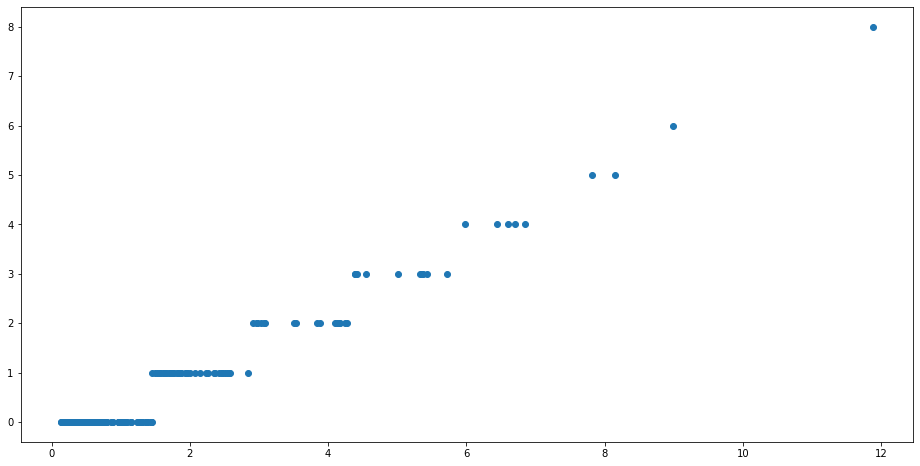

In [23]:
f, ax = plt.subplots(figsize=(16,8))
_ = ax.scatter(
    bids,
    assigned_tokens
)

As we can see there is always a range of bids (on the x axes) which results in a certain number of tokens being assigned. This is due to the "rounding" logic in distribution. 

Sidenote: The overlap in the dots for the groups getting 0 or 1 tokens is actually because we do not simulate the distribution in an ordered fashion here. It can be ignored.

# Wrap-Up

Given this relatively simple brute-force approach we achieve an optimal distribution in acceptable time.